# PyTorch - CNN

In [1]:
import torch
import torch.nn as nn #defining neural network
import torch.nn.functional as F #helper
from torch.utils.data import DataLoader #batching
from torchvision import datasets, transforms #loading datasets
from torchvision.utils import make_grid  #for visualization

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# !pip install torchvision
import torchvision
torchvision.__version__

'0.16.0'

In [3]:
#to help serve as "alternative" cross-validation in deep learning
torch.manual_seed(22)

## 1. Load the dataset

In [4]:
#define some transforms (convert 0-255 to 0-1)
transform = transforms.ToTensor()
#if you want to crop the image, rotate the image; they are all done in this transform

#use pytorch datasets to load MNIST - dataset of digit images
#train
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

#validation set
train_set, val_set = torch.utils.data.random_split(train_data, [50000, 10000])

#test
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [5]:
val_set

## 2. Dataloaders

In [6]:
#CUDA out of memory

In [7]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)  #this shuffle will depend on our seed
val_loader   = DataLoader(val_set,   batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=10000, shuffle=False) #because no training

In [8]:
len(train_loader)  #782 * 64 = 50,048 = 50000 + 48

782

3

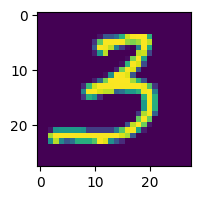

In [9]:
for images, labels in train_loader:  #taking 64 images, corresponding 64 labels
    break

images.shape #(64 images, 1 channel, height, width)
labels.shape #(class for the 64 images)

the_image = images[0]
the_image = np.transpose(the_image, (1, 2, 0))
the_image.shape
plt.figure(figsize=(2, 2))
plt.imshow(the_image) #(h, w, c)

labels[0].item()

## 3. Define the network

In [10]:
images.shape #input (bs, ch, h, w)

torch.Size([64, 1, 28, 28])

In [11]:
#understanding the relationship between the input and convolutional layer -> output
#conv1d = time series, language, signal
#conv2d = images, spectrograms
# layer1 = nn.Con
# nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1)
layer1 = nn.Conv2d(1, 1, 3, 1, 1)

$$O = \frac{I-F+2P}{S} + 1$$

I = image width/height, F = filter size, P = padding, S = stride, O = output width/height

In [12]:
#how to pass something into this layer
output = layer1(images)
output.shape #(bs, out_channel, h, w)

torch.Size([64, 1, 28, 28])

In [13]:
layer1 = nn.Conv2d(1, 5, 3, 1, 1)
layer2 = nn.Conv2d(5, 10, 3, 1, 1)
layer3 = nn.Linear(10 * 28 * 28, 120)
out = layer2(layer1(images))
out = out.reshape((-1, 10*28*28))
out2 = layer3(out)
out2.shape

torch.Size([64, 120])

In [14]:
class Chaky_CNN(nn.Module):
    
    def __init__(self): #init all hyperparameters and layers
        super().__init__() #inherit everything from nn.Module
        self.layer1 = nn.Conv2d(1, 5, 3, 1, 1) 
        self.layer2 = nn.Conv2d(5, 10, 3, 1, 1)
        self.layer3 = nn.Linear(10 * 28 * 28, 120)
        self.layer4 = nn.Linear(120, 84) #why 120, 84 - chaky examples
        self.layer5 = nn.Linear(84, 10)  #why 10, 10 classes
        
    def forward(self, images):  #performing the forward pass through all layers
        out = F.relu(self.layer1(images))
        out = F.relu(self.layer2(out))
        out = out.reshape((-1, 10*28*28))
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = self.layer5(out)
        return out        

In [15]:
#test first
chaky_model = Chaky_CNN()
output      = chaky_model(images)
output.shape

torch.Size([64, 10])

In [16]:
#skip counting the parameters

## 4. Define the loss and optimizer

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(chaky_model.parameters(), lr=0.01)

## 5. Train!!

In [24]:
num_epochs = 1
for i in range(num_epochs):
    for images, labels in train_loader:
        y_hat = chaky_model(images)
        loss  = criterion(y_hat, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [26]:
loss.item()

0.01282444130629301

## 6. Testing

In [27]:
chaky_model.eval() #this will turn off dropout, batch norm
with torch.no_grad():  #this will turn off gradient calculations
    for images, labels in test_loader:
        y_hat = chaky_model(images)
        loss = criterion(y_hat, labels)
        
print("Cross Entrophy Loss: ", loss.item())

Cross Entrophy Loss:  0.08785514533519745


## 7. Analysis

In [34]:
y_hat_pred = torch.max(y_hat, 1)[1]
y_hat_pred.shape

torch.Size([10000])

In [35]:
#confusion matrix
confusion_matrix(y_hat_pred, labels)

array([[ 969,    0,   14,    1,    0,    3,    8,    1,    4,    6],
       [   0, 1127,    1,    0,    0,    0,    6,    5,    1,    1],
       [   3,    1,  995,    2,    1,    0,    0,    6,    6,    0],
       [   0,    2,    4,  997,    0,   11,    1,    2,    1,    1],
       [   1,    1,    2,    0,  974,    0,   17,    0,    9,   24],
       [   3,    0,    0,    0,    0,  867,    6,    0,    2,    2],
       [   1,    0,    0,    0,    0,    5,  918,    0,    0,    0],
       [   2,    2,   15,    6,    3,    4,    0, 1013,    8,   22],
       [   1,    2,    1,    3,    1,    0,    2,    0,  933,    0],
       [   0,    0,    0,    1,    3,    2,    0,    1,   10,  953]])

## 8. Inference

In [39]:
test_data[0][0].shape
test_data[0][1]

7

In [41]:
# plt.imshow(np.transpose(test_data[0][0], (1, 2, 0)))

In [42]:
pred = chaky_model(test_data[0][0])

In [45]:
pred

tensor([[-11.9412,  -2.8596,   3.3668,  -1.0450,  -6.3315,  -8.5397, -27.3065,
          18.4977,  -8.6600,  -0.6668]], grad_fn=<AddmmBackward0>)